<h1 align="center">Navigating dandiset 000728: Visual Coding - Optical Physiology</h1> 

In [1]:
import os
import json
import pathlib
import warnings
from typing import Union, Tuple, Literal

import h5py
import matplotlib
import numpy
import pandas
import pynwb
import remfile
import scipy.stats as scipy_stats
import matplotlib.pyplot as matplotlib_pyplot
from dandi.dandiapi import DandiAPIClient, RemoteAsset, RemoteDandiset

In [2]:
%matplotlib inline

<div style="background: #C6D9F1; border-radius: 5px; padding: 10px;">

<h1> Part 1: Getting oriented to the dataset</h1>

</div>

Alongside this notebook are included two JSON files that contain high-level metadata of the experiments - the conditions under which each was acquired.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's take a look at some of the fields in these metadata structures, such as <b>imaging depths</b>, <b>cre lines</b>, <b>areas</b>, and <b>stimuli</b> available in the Visual Coding - Optical Physiology dataset.
</div>

In [3]:
# You may need to change these paths to the files depending on your current working directory
# These defaults assume the current working directory is the folder containing this notebook 

asset_metadata_folder_path = pathlib.Path("asset_metadata")
experiment_containers_metadata_file_path = asset_metadata_folder_path / "experiment_containers_metadata.json"
visual_coding_sessions_metadata_file_path = asset_metadata_folder_path / "visual_coding_sessions_metadata.json"

In [4]:
with open(file=experiment_containers_metadata_file_path, mode="r") as fp:
    experiment_containers_metadata = json.load(fp=fp)
with open(file=visual_coding_sessions_metadata_file_path, mode="r") as fp:
    visual_coding_sessions_metadata = json.load(fp=fp)

Start by getting all the areas, which are referred to as "targeted structures".

In [5]:
all_targeted_structures = list(set([experiment_container["targeted_structure"] for experiment_container in experiment_containers_metadata]))
all_targeted_structures

['VISal', 'VISam', 'VISp', 'VISrl', 'VISpm', 'VISl']

Then use a similar approach to get all imaging depths, all cre lines, all reporter lines, all stimuli, and all session types

In [6]:
all_cre_lines = list(set([experiment_container["cre_line"] for experiment_container in experiment_containers_metadata]))
all_cre_lines

['Nr5a1-Cre',
 'Rorb-IRES2-Cre',
 'Ntsr1-Cre_GN220',
 'Vip-IRES-Cre',
 'Emx1-IRES-Cre',
 'Sst-IRES-Cre',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Fezf2-CreER',
 'Scnn1a-Tg3-Cre',
 'Tlx3-Cre_PL56',
 'Cux2-CreERT2',
 'Slc17a7-IRES2-Cre']

In [7]:
all_reporter_lines = list(set([experiment_container["reporter_line"] for experiment_container in experiment_containers_metadata]))
all_reporter_lines

['Ai93(TITL-GCaMP6f)-hyg',
 'Ai93(TITL-GCaMP6f)',
 'Ai162(TIT2L-GC6s-ICL-tTA2)',
 'Ai148(TIT2L-GC6f-ICL-tTA2)',
 'Ai94(TITL-GCaMP6s)']

In [8]:
all_session_types = list(set([session["session_type"] for session in visual_coding_sessions_metadata]))
all_session_types

['three_session_A', 'three_session_B', 'three_session_C2', 'three_session_C']

The following figure is a good reference for describing the main differences between each session type with respect to the visual stimuli used.

!['Diagram of containers'](http://alleninstitute.github.io/AllenSDK/_static/container_session_layout.png)

## 1.1 Experiment containers & sessions

The <b>experiment container</b> describes a set of 3 imaging sessions performed for the same field of view (ie. same targeted area and imaging depth in the same mouse that targets the same set of neurons).

Each experiment container has a unique <b>session ID</b>. This, together with the <b>subject ID</b>, will allow us to identify the NWB file from which to access the data from.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's choose a visual area and Cre line from the lists above.
<br><br>
Using the metadata in this table, we can find all the experiment containers for this area and Cre line.
</div>

In [9]:
experiments_subset = [
    experiment_container
    for experiment_container in experiment_containers_metadata
    if experiment_container["targeted_structure"] == "VISp" and experiment_container["cre_line"] == "Cux2-CreERT2"
]
experiment_subset_table = pandas.DataFrame(experiments_subset)
experiment_subset_table

id  imaging_depth targeted_structure      cre_line  \
0   511510736            175               VISp  Cux2-CreERT2   
1   511510855            175               VISp  Cux2-CreERT2   
2   511509529            175               VISp  Cux2-CreERT2   
3   511507650            175               VISp  Cux2-CreERT2   
4   702934962            275               VISp  Cux2-CreERT2   
5   645413757            275               VISp  Cux2-CreERT2   
6   659767480            275               VISp  Cux2-CreERT2   
7   511510650            175               VISp  Cux2-CreERT2   
8   712178509            275               VISp  Cux2-CreERT2   
9   511510667            275               VISp  Cux2-CreERT2   
10  524691282            275               VISp  Cux2-CreERT2   
11  701412138            175               VISp  Cux2-CreERT2   
12  511510718            175               VISp  Cux2-CreERT2   
13  511510699            275               VISp  Cux2-CreERT2   
14  511510779            275               VISp  Cux2-CreERT2   
15  511510670            175               VISp  Cux2-CreERT2   

         reporter_line donor_name                        specimen_name tags  \
0   Ai93(TITL-GCaMP6f)     222426  Cux2-CreERT2;Camk2a-tTA;Ai93-222426   []   
1   Ai93(TITL-GCaMP6f)     229106  Cux2-CreERT2;Camk2a-tTA;Ai93-229106   []   
2   Ai93(TITL-GCaMP6f)     222420  Cux2-CreERT2;Camk2a-tTA;Ai93-222420   []   
3   Ai93(TITL-GCaMP6f)     222424  Cux2-CreERT2;Camk2a-tTA;Ai93-222424   []   
4   Ai93(TITL-GCaMP6f)     382421  Cux2-CreERT2;Camk2a-tTA;Ai93-382421   []   
5   Ai93(TITL-GCaMP6f)     348262  Cux2-CreERT2;Camk2a-tTA;Ai93-348262   []   
6   Ai93(TITL-GCaMP6f)     360565  Cux2-CreERT2;Camk2a-tTA;Ai93-360565   []   
7   Ai93(TITL-GCaMP6f)     222425  Cux2-CreERT2;Camk2a-tTA;Ai93-222425   []   
8   Ai93(TITL-GCaMP6f)     390323  Cux2-CreERT2;Camk2a-tTA;Ai93-390323   []   
9   Ai93(TITL-GCaMP6f)     222420  Cux2-CreERT2;Camk2a-tTA;Ai93-222420   []   
10  Ai93(TITL-GCaMP6f)     243293  Cux2-CreERT2;Camk2a-tTA;Ai93-243293   []   
11  Ai93(TITL-GCaMP6f)     382421  Cux2-CreERT2;Camk2a-tTA;Ai93-382421   []   
12  Ai93(TITL-GCaMP6f)     231584  Cux2-CreERT2;Camk2a-tTA;Ai93-231584   []   
13  Ai93(TITL-GCaMP6f)     225037  Cux2-CreERT2;Camk2a-tTA;Ai93-225037   []   
14  Ai93(TITL-GCaMP6f)     225036  Cux2-CreERT2;Camk2a-tTA;Ai93-225036   []   
15  Ai93(TITL-GCaMP6f)     225037  Cux2-CreERT2;Camk2a-tTA;Ai93-225037   []   

    failed  
0    False  
1    False  
2    False  
3    False  
4    False  
5    False  
6    False  
7    False  
8    False  
9    False  
10   False  
11   False  
12   False  
13   False  
14   False  
15   False

In [10]:
number_of_experiment_containers = len(experiment_containers_metadata)
number_of_experiment_containers

540

Let's look at one experiment container, imaged from <b>Cux2</b>, in <b>VISp</b>, from imaging depth <b>175 um</b>.

In [11]:
experiment_container_id = experiments_subset[0]["id"]
experiment_container_id

511510736

In [12]:
sessions = [
    visual_coding_session for visual_coding_session in visual_coding_sessions_metadata
    if visual_coding_session["experiment_container_id"] == experiment_container_id
]
sessions_table = pandas.DataFrame(sessions)
sessions_table

id  imaging_depth targeted_structure      cre_line  \
0  501559087            175               VISp  Cux2-CreERT2   
1  501704220            175               VISp  Cux2-CreERT2   
2  501474098            175               VISp  Cux2-CreERT2   

        reporter_line  acquisition_age_days  experiment_container_id  \
0  Ai93(TITL-GCaMP6f)                   103                511510736   
1  Ai93(TITL-GCaMP6f)                   104                511510736   
2  Ai93(TITL-GCaMP6f)                   102                511510736   

      session_type donor_name                        specimen_name  \
0  three_session_B     222426  Cux2-CreERT2;Camk2a-tTA;Ai93-222426   
1  three_session_A     222426  Cux2-CreERT2;Camk2a-tTA;Ai93-222426   
2  three_session_C     222426  Cux2-CreERT2;Camk2a-tTA;Ai93-222426   

   fail_eye_tracking  
0               True  
1               True  
2               True

Let's get the id for the imaging session in this experiment container that used <b>session type B</b>.

In [13]:
session_id = [session for session in sessions if session["session_type"] == "three_session_B"][0]["id"]
session_id

501559087

<div style="background: #C6D9F1; border-radius: 5px; padding: 10px;">

<h1> Part 2: Streaming all the data for a single session</h1>


</div>

Start by defining some quick helper functions...

In [14]:
def read_dandi_file(*, asset: RemoteAsset) -> pynwb.NWBFile:
    """Remotely load the NWB file from a DANDI asset object."""
    # Harmless warnings from PyNWB
    warnings.filterwarnings(action="ignore", message="No cached namespaces found in .*")
    warnings.filterwarnings(action="ignore", message="Ignoring cached namespace .*")
    
    s3_url = asset.get_content_url()
    byte_stream = remfile.File(url=s3_url)
    file = h5py.File(name=byte_stream)
    io = pynwb.NWBHDF5IO(file=file, mode="r", load_namespaces=True)
    nwbfile = io.read()

    return nwbfile

In [15]:
def read_visual_coding_ophys_file(
    *, dandiset: RemoteDandiset, session_id: str, raw_or_processed: Literal["raw", "processed"] = "processed"
) -> pynwb.NWBFile:
    """Load the NWB file from DANDI given only the unique session ID in the Visual Coding - Optical Physiology dataset."""
    if raw_or_processed == "processed":
        asset = next(asset for asset in dandiset.get_assets() if f"ses-{session_id}" in asset.path and "behavior" in asset.path)
    elif raw_or_processed == "raw":
        asset = next(asset for asset in dandiset.get_assets() if f"ses-{session_id}" in asset.path and "behavior" not in asset.path)
    return read_dandi_file(asset=asset)

Now we start streaming data directly from the DANDI Archive! Instead of downloading each entire file (usually around 500 MB; and there are 1518 files!), streaming simply requests the minimal amount of data needed to perform an immediate operation.

We begin by connecting a client and fetching the dandiset object.

In [16]:
dandiset_id = "000728"

client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id=dandiset_id)

Now we can load the NWB file from the dandiset that corresponds to our session ID.

In [17]:
nwbfile = read_visual_coding_ophys_file(dandiset=dandiset, session_id=session_id)

Try exploring the file contents interactively by expanding the dropdowns!

In [18]:
nwbfile

root pynwb.file.NWBFile at 0x1816049396304
Fields:
  data_collection: Generated by pipeline Brain Observatory version 3.0.
  devices: {
    Camera <class 'pynwb.device.Device'>,
    Microscope <class 'pynwb.device.Device'>,
    StimulusDisplay <class 'pynwb.device.Device'>
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  experiment_description: For more information, please see http://help.brain-map.org/display/observatory/Allen+Brain+Observatory
  file_create_date: [datetime.datetime(2024, 3, 19, 15, 55, 50, 497145, tzinfo=tzoffset(None, -14400))]
  identifier: 211c0e3c-4b28-4375-b539-cdb71a42851b
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Allen Institute for Brain Science
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>
  }
  notes: Container ID: 511510736
Mouse ID (from genotype white paper): 222426
Session type: three_session_B
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>,
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  protocol: 20160204_222426_3StimB
  session_description: Auto-generated by neuroconv
  session_id: 501559087-StimB
  session_start_time: 2016-02-04 10:25:24-08:00
  stimulus: {
    natural_movie_one_stimulus <class 'pynwb.image.IndexSeries'>,
    natural_scenes_stimulus <class 'pynwb.image.IndexSeries'>,
    spontaneous_stimulus <class 'pynwb.epoch.TimeIntervals'>,
    static_gratings <class 'pynwb.epoch.TimeIntervals'>
  }
  stimulus_template: {
    natural_movie_one <class 'pynwb.image.ImageSeries'>,
    natural_scenes_template <class 'pynwb.base.Images'>
  }
  subject: subject pynwb.file.Subject at 0x1816077891280
Fields:
  age: P104D
  age__reference: birth
  description: Mus musculus in vivo.
  genotype: Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)
  sex: M
  species: Mus musculus
  strain: Cux2-CreERT2;Camk2a-tTA;Ai93-222426
  subject_id: 495727015

  timestamps_reference_time: 2016-02-04 10:25:24-08:00

<div style="background: #C6D9F1; border-radius: 5px; padding: 10px;">

<h1> Part 3: Loading specific fields of the data for a single session</h1>


</div>

Begin by defining some plotting functions to simplify cells throughout the later sections...

In [19]:
def plot_image(
    *,  # "*" character forces keyword argument usage, which makes code much more readable
    image: numpy.ndarray,
    size: int = 8,
    color_map: Union[str, None] = None
) -> None:
    """
    Pretty rendering of a simple square grayscale image.
    
    Axis labels and ticks are stripped since their size is viewable from the image array shape.
    Also, display the color bar at a good size if color is not gray.
    """
    matplotlib_pyplot.figure(figsize=(size, size))

    frame = matplotlib_pyplot.gca()
    for label in frame.axes.get_xticklabels():
        label.set_visible(False)
        label.set_fontsize(0.0)
    for label in frame.axes.get_yticklabels():
        label.set_fontsize(0.0)
        label.set_visible(False)
    for tick in frame.axes.get_xticklines():
        tick.set_visible(False)
    for tick in frame.axes.get_yticklines():
        tick.set_visible(False)
    
    plot = matplotlib_pyplot.imshow(image, cmap=color_map);

    if color_map != "gray":
        color_bar = matplotlib_pyplot.colorbar(plot, fraction=0.046, pad=0.04)
        color_bar.solids.set_edgecolor("face")

In [20]:
def plot_traces(
    *,
    timestamps: numpy.ndarray,
    traces: numpy.ndarray,
    hide_y_scale: bool = True,
    x_axis_label: Union[str, None] = "Time (s)",  # Since timestamps in seconds are so common in NWB, just make it the default
    y_axis_label: Union[str, None] = None,
    padding: float = 2.0,
    trace_color: Union[str, None] = None,
    reset_figure: bool = True,
    figure_shape: Tuple[int, int] = (10, 4),
    return_frame: bool = False,
) -> Union[matplotlib.axes.Axes, None]:
    """
    Pretty rendering of traces of activity (such as ROI or running speed) over time.

    The Y axis of ROI traces is rarely known in practice, so numerical scale doesn't really matter for plotting.
    Also, timestamps from NWB will always be in seconds.
    """
    if reset_figure:
        matplotlib_pyplot.figure(figsize=figure_shape)

    if len(traces.shape) == 1:
        matplotlib_pyplot.plot(timestamps, traces, color=trace_color)
    else:
        for trace_index in range(traces.shape[1]):
            matplotlib_pyplot.plot(
                timestamps,
                traces[:, trace_index] + (trace_index * padding), # Add vertical padding to separate each trace
                color=trace_color,
            )

    frame = matplotlib_pyplot.gca()
    frame.axes.spines['top'].set_visible(False)
    frame.axes.spines['right'].set_visible(False)
    frame.axes.spines['bottom'].set_visible(False)
    frame.axes.spines['left'].set_visible(False)

    if hide_y_scale:
        for label in frame.axes.get_yticklabels():
            label.set_fontsize(0.0)
            label.set_visible(False)
        for tick in frame.axes.get_yticklines():
            tick.set_visible(False)

    matplotlib_pyplot.xlabel(x_axis_label, fontsize=16)
    if y_axis_label is not None:
        matplotlib_pyplot.ylabel(y_axis_label, fontsize=16)

    if return_frame:
        return frame

In [21]:
def apply_epoch_shading(
    *,
    frame: matplotlib.axes.Axes,
    epoch_table: pynwb.file.TimeIntervals,
) -> None:
    """For each epoch, shade the plot based on the stimulus type."""
    # Clear previous legend to prevent appending
    frame.legend([])
    
    epoch_table_data_frame = epoch_table.to_dataframe()

    stimulus_type_to_color = dict(
        spontaneous="grey",
        static_gratings="fuchsia",
        drifting_gratings="lavender",
        natural_scenes="orange",
        natural_movie_one="green",
        natural_movie_two="red",
        natural_movie_three="blue",
    )
    stimulus_type_to_label = dict(
        spontaneous="Spontaneous",
        static_gratings="Static Gratings",
        drifting_gratings="Drifting Gratings",
        natural_scenes="Natural Scenes",
        natural_movie_one="Natural Movie (1)",
        natural_movie_two="Natural Movie (2)",
        natural_movie_three="Natural Movie (3)",
    )

    patches= list()
    for stimulus_name in epoch_table_data_frame.stimulus_type.unique():
        stimulus = epoch_table_data_frame[epoch_table_data_frame.stimulus_type==stimulus_name]

        if len(stimulus) > 0:
            patches.append(
                matplotlib.patches.Patch(
                    color=stimulus_type_to_color[stimulus_name],
                    label=stimulus_type_to_label[stimulus_name],
                    alpha=0.1,
                )
            )

        for _, row in stimulus.iterrows():
            frame.axvspan(
                xmin=row.start_time, xmax=row.stop_time, color=stimulus_type_to_color[stimulus_name], alpha=0.1
            )

    frame.legend(title="Epochs", loc="center left", handles=patches, shadow=True, fancybox=True, bbox_to_anchor=(1, 0.5));

## 3.0 Raw Motion Corrected Movies

Most of the sessions in this dataset have the full original motion corrected microscopy data available - that would be around 80 TB if we uncompressed it!

Thankfully, we never need to download the data (unless we want to work offline).

However, since people do like to occasionally download local copies of the processed data, the raw data is stored in separate files that are accessed less frequently.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's plot a few frames from the microscopy to see what it looks like.
</div>

In [22]:
nwbfile_with_raw_imaging = read_visual_coding_ophys_file(dandiset=dandiset, session_id=session_id, raw_or_processed="raw")
nwbfile_with_raw_imaging

root pynwb.file.NWBFile at 0x1816073478928
Fields:
  acquisition: {
    MotionCorrectedTwoPhotonSeries <class 'pynwb.ophys.TwoPhotonSeries'>,
    MotionCorrectionShiftsPerFrame <class 'pynwb.base.TimeSeries'>
  }
  data_collection: Generated by pipeline Brain Observatory version 3.0.
  devices: {
    Microscope <class 'pynwb.device.Device'>
  }
  experiment_description: For more information, please see http://help.brain-map.org/display/observatory/Allen+Brain+Observatory
  file_create_date: [datetime.datetime(2024, 3, 23, 1, 3, 19, 871158, tzinfo=tzoffset(None, -14400))]
  identifier: 8bc0aa1c-49f6-4e35-a90b-ddc2b7cc7bc0
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Allen Institute for Brain Science
  notes: Container ID: 511510736
Mouse ID (from genotype white paper): 222426
Session type: three_session_B
  protocol: 20160204_222426_3StimB
  session_description: 2-photon recording of visual areas in head-fixed mouse with visual stimulus.

Monitor was positioned 15 cm from the mouse's eye, and spanned 120 degrees x 95 degrees of visual space without accounting for stimulus warping.

Each monitor was gamma corrected using a USB-650 Red Tide Spectrometer (Ocean Optics). Luminance was measured using a SpectroCAL MKII Spectroradiometer (Cambridge Research Systems). Monitors were used at a brightness setting of 30% and contrast at 50%, corresponding to mean luminance of 50 cd/m^2.

  session_id: 501559087-StimB
  session_start_time: 2016-02-04 10:25:24-08:00
  subject: subject pynwb.file.Subject at 0x1816071293776
Fields:
  age: P104D
  age__reference: birth
  description: Mus musculus in vivo.
  genotype: Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)
  sex: M
  species: Mus musculus
  strain: Cux2-CreERT2;Camk2a-tTA;Ai93-222426
  subject_id: 495727015

  timestamps_reference_time: 2016-02-04 10:25:24-08:00

In [23]:
motion_corrected_imaging = nwbfile_with_raw_imaging.acquisition["MotionCorrectedTwoPhotonSeries"]
motion_corrected_imaging

MotionCorrectedTwoPhotonSeries pynwb.ophys.TwoPhotonSeries at 0x1816077527568
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (113888, 512, 512), type "<u2">
  description: Motion corrected flourescence from calcium imaging recording. Refer to the 'MotionCorrectionShiftsPerFrame' series to see how each frame was shifted.
  imaging_plane: ImagingPlane pynwb.ophys.ImagingPlane at 0x1816077524368
Fields:
  conversion: 1.0
  description: The imaging plane sampled by the two-photon calcium imaging at a depth of {depth} µm.
  device: Microscope pynwb.device.Device at 0x1816077455632
Fields:
  description: A Nikon A1R-MP multiphoton microscope. This system was adapted to provide space to accommodate the behavior apparatus.
  manufacturer: Nikon

  excitation_lambda: 910.0
  indicator: GCaMP6f
  location: VISp
  optical_channel: (
    OpticalChannel <class 'pynwb.ophys.OpticalChannel'>
  )
  unit: meters

  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamp_link: (
    MotionCorrectionShiftsPerFrame <class 'pynwb.base.TimeSeries'>
  )
  timestamps: <HDF5 dataset "timestamps": shape (113888,), type "<f8">
  timestamps_unit: seconds
  unit: n.a.

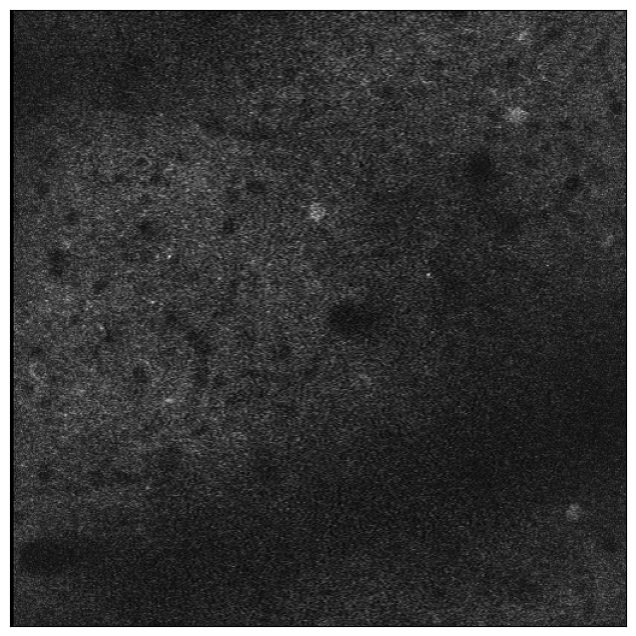

In [24]:
plot_image(image=motion_corrected_imaging.data[3_000, ...], color_map="gray")

That looks pretty noisy! The following sections will examine what the data looks like after it's been thoroughly cleaned.

## 3.1 Maximum projection
This is the projection of the full motion corrected movie. It shows all of the cells imaged during the session.

In [25]:
maximum_intensity_projection = nwbfile.processing["ophys"]["SummaryImages"]["maximum_intensity_projection"][:]
maximum_intensity_projection

array([[ 296,  308,  306, ..., 2760, 2164,  888],
       [ 312,  298,  303, ..., 2741, 1716, 1031],
       [ 278,  295,  298, ..., 1426,  929,  574],
       ...,
       [ 347,  348,  366, ...,  407,  403,  410],
       [ 335,  357,  398, ...,  317,  354,  362],
       [ 308,  288,  306, ...,  293,  316,  318]], dtype=uint16)

In [26]:
maximum_intensity_projection.shape

(512, 512)

<div class="alert alert-block alert-info">
The slicing operation <code>[:]</code> is what triggers the data to be sent from the archive. You can even limit the amount of data requested by choosing a subrange!
</div>

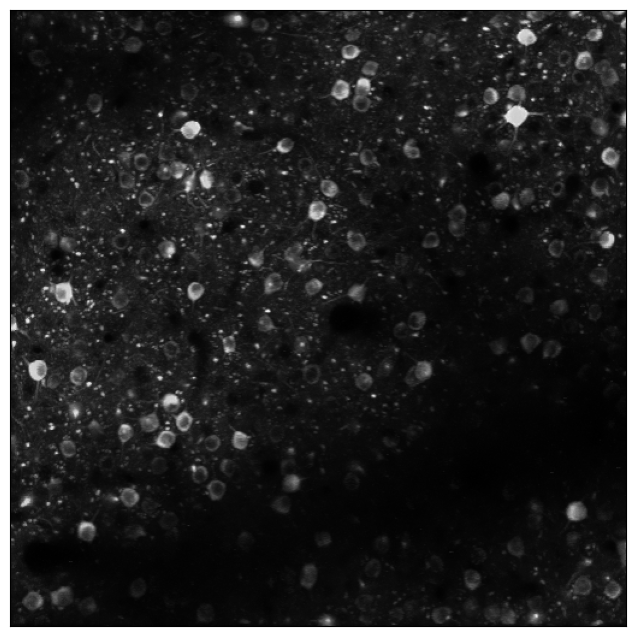

In [27]:
plot_image(image=maximum_intensity_projection, color_map="gray")

## 3.2 PlaneSegmentation

These are all of the segmented masks for cell bodies in this experiment. We can view a table summary of these by calling `to_dataframe()`.

In [28]:
plane_segmentation = nwbfile.processing["ophys"]["ImageSegmentation"]["PlaneSegmentation"]
plane_segmentation_table = plane_segmentation.to_dataframe()
plane_segmentation_table

global_roi_id                                         pixel_mask
id                                                                         
517473350      517473350  [[55, 291, 1.0], [55, 292, 1.0], [56, 290, 1.0...
517473341      517473341  [[58, 272, 1.0], [58, 273, 1.0], [58, 274, 1.0...
517473313      517473313  [[33, 459, 1.0], [33, 460, 1.0], [33, 461, 1.0...
517473255      517473255  [[41, 493, 1.0], [41, 494, 1.0], [41, 495, 1.0...
517471959      517471959  [[19, 346, 1.0], [19, 347, 1.0], [19, 348, 1.0...
...                  ...                                                ...
517473240      517473240  [[127, 125, 1.0], [127, 126, 1.0], [127, 127, ...
587376723      587376723  [[132, 187, 1.0], [132, 188, 1.0], [132, 189, ...
517472450      517472450  [[129, 87, 1.0], [130, 87, 1.0], [130, 88, 1.0...
517473191      517473191  [[195, 264, 1.0], [195, 265, 1.0], [195, 266, ...
517471925      517471925  [[157, 160, 1.0], [158, 160, 1.0], [158, 161, ...

[174 rows x 2 columns]

Notice that each cell in the dataset has two IDs: a <b>local ID</b> specific to this table and session, and a <b>unique global ID</b>.

The <b>global ID</b> can be used to find experiments/session for a specified cell. It is also valuable for finding the matched cell across sessions for the same experiment container (e.g., if you want to compare a cell's response to drifting gratings with its response the natural scenes).

Pixel masks are a data structure that record a list of pixels (width x height) and weights that outline each ROI.

In [29]:
pixel_masks = plane_segmentation["pixel_mask"][:]
pixel_masks

[array([(55, 291, 1.), (55, 292, 1.), (56, 290, 1.), (56, 291, 1.),
        (56, 292, 1.), (56, 293, 1.), (56, 294, 1.), (56, 295, 1.),
        (56, 296, 1.), (57, 289, 1.), (57, 290, 1.), (57, 291, 1.),
        (57, 292, 1.), (57, 293, 1.), (57, 294, 1.), (57, 295, 1.),
        (57, 296, 1.), (57, 297, 1.), (57, 298, 1.), (58, 288, 1.),
        (58, 289, 1.), (58, 290, 1.), (58, 291, 1.), (58, 292, 1.),
        (58, 293, 1.), (58, 294, 1.), (58, 295, 1.), (58, 296, 1.),
        (58, 297, 1.), (58, 298, 1.), (58, 299, 1.), (59, 288, 1.),
        (59, 289, 1.), (59, 290, 1.), (59, 291, 1.), (59, 292, 1.),
        (59, 293, 1.), (59, 294, 1.), (59, 295, 1.), (59, 296, 1.),
        (59, 297, 1.), (59, 298, 1.), (59, 299, 1.), (60, 288, 1.),
        (60, 289, 1.), (60, 290, 1.), (60, 291, 1.), (60, 292, 1.),
        (60, 293, 1.), (60, 294, 1.), (60, 295, 1.), (60, 296, 1.),
        (60, 297, 1.), (60, 298, 1.), (60, 299, 1.), (61, 287, 1.),
        (61, 288, 1.), (61, 289, 1.), (61, 290, 

In [30]:
combined_image_masks = numpy.zeros(shape=maximum_intensity_projection.shape)
for pixel_mask in plane_segmentation["pixel_mask"][:]:
    for x, y, w in pixel_mask:
        combined_image_masks[x,y] += w

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's plot the image mask aggregated over all the ROIs.
<br><br>   
Brighter values indicate overlap across multiple ROIs (since all of our weights are <code>1.0</code>).
</div>

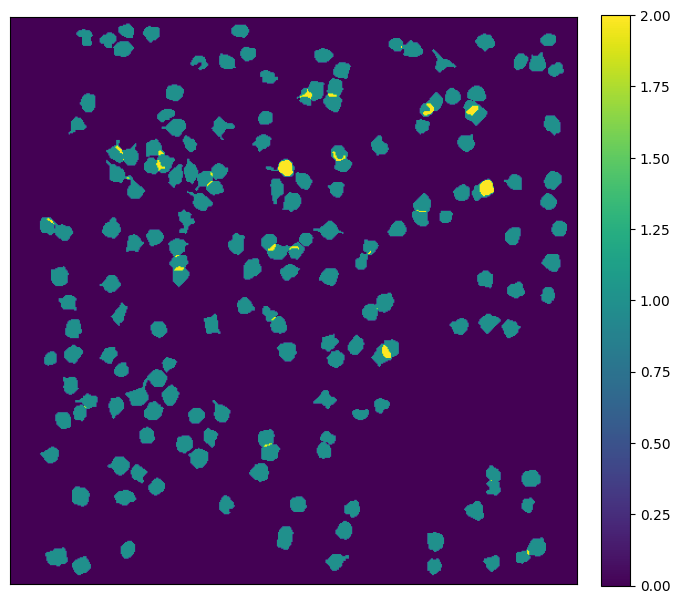

In [31]:
plot_image(image=combined_image_masks)

## 3.3 Segmented and Processed Traces

There are a number of accessible traces in the NWB file, including raw fluorescence, neuropil corrected traces, demixed traces, and $\Delta F / F$ traces.

These are split across two containers; the `DfOverF` (containing only a single calculated trace) and `Fluorescence` from which it was calculated (containing three individual steps of the processing pipeline).

Be sure to read the `description` of each object to understand how they relate to each other! The following image from the Allen Institute does a good job explaining the workflow.

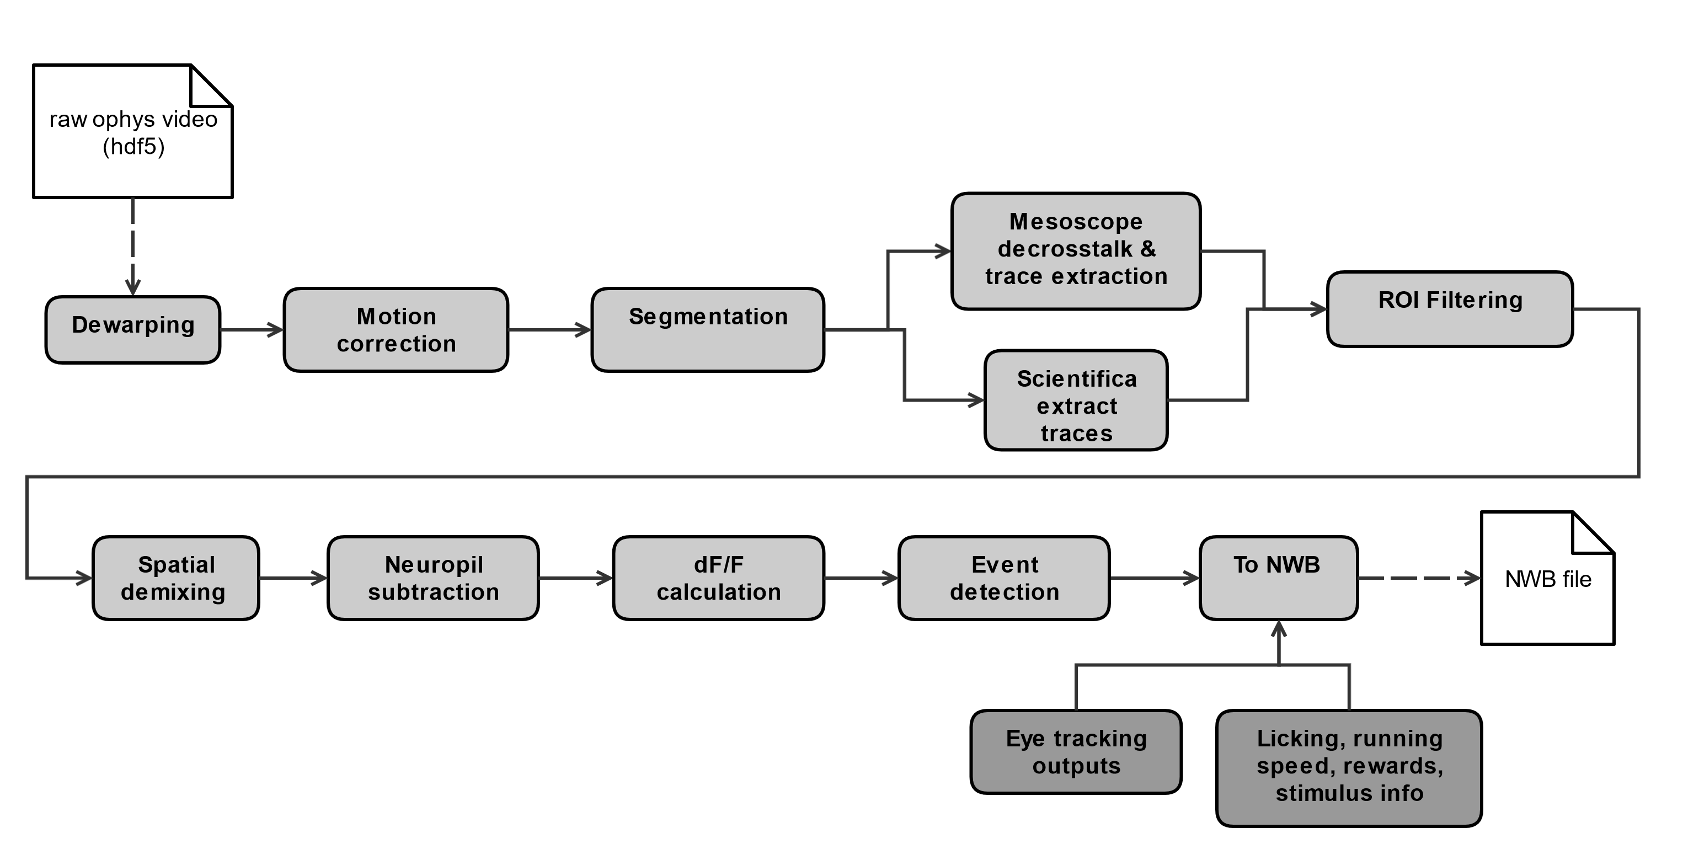

In [32]:
nwbfile.processing["ophys"]["DfOverF"]

DfOverF pynwb.ophys.DfOverF at 0x1816068558352
Fields:
  roi_response_series: {
    DfOverF <class 'pynwb.ophys.RoiResponseSeries'>,
    DfOverFEvents <class 'pynwb.ophys.RoiResponseSeries'>
  }

In [33]:
nwbfile.processing["ophys"]["Fluorescence"]

Fluorescence pynwb.ophys.Fluorescence at 0x1816077528208
Fields:
  roi_response_series: {
    Corrected <class 'pynwb.ophys.RoiResponseSeries'>,
    Demixed <class 'pynwb.ophys.RoiResponseSeries'>,
    Neuropil <class 'pynwb.ophys.RoiResponseSeries'>
  }

Let's examine the $\Delta F / F$ activity of the first ROI.

In [34]:
df_over_f = nwbfile.processing["ophys"]["DfOverF"]["DfOverF"].data
df_over_f_timestamps = nwbfile.processing["ophys"]["DfOverF"]["DfOverF"].timestamps[...]

<div class="alert alert-block alert-info">
By setting our variable <code>df_over_f</code> to the <code>.data</code>, but not slicing it like we did <code>.timestamps[:]</code>, we are delaying the downloading of any data until we determine which ROI or frame indices we want to select in the cell below.
</div>

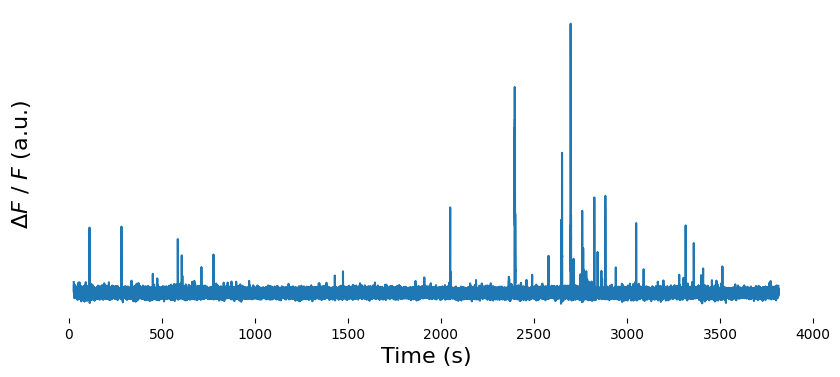

In [35]:
roi_index = 0

plot_traces(timestamps=df_over_f_timestamps, traces=df_over_f[:, roi_index], y_axis_label = "$\Delta F \ / \ F$ (a.u.)")

We can examine a narrower time window by slicing the frames (the first axis of the `data`) - but we have to take care to apply the same frame selection to both the `data` and the `timestamps`.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's start by seeing how many frames we have in total, then choose a subselection.
</div>

In [36]:
df_over_f_timestamps.shape

(113888,)

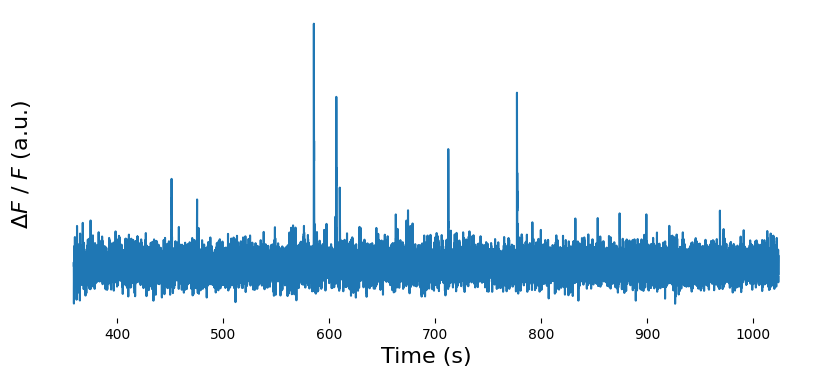

In [37]:
frame_slice = slice(10_000, 30_000)

plot_traces(timestamps=df_over_f_timestamps[frame_slice], traces=df_over_f[frame_slice, roi_index], y_axis_label = "$\Delta F \ / \ F$ (a.u.)")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Now, let's look at the first 50 ROIs. 
</div>

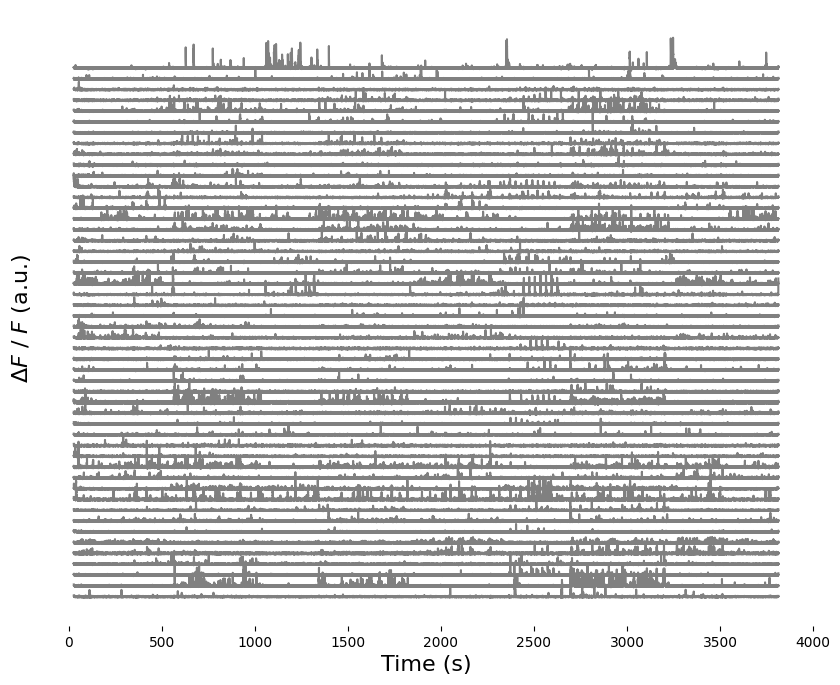

In [38]:
plot_traces(
    timestamps=df_over_f_timestamps,
    traces=df_over_f[:, 0:50],
    figure_shape=(10, 8),
    y_axis_label = "$\Delta F \ / \ F$ (a.u.)",
    trace_color="gray",
)

It looks like different cells are active at different times. What could that be about?

## 3.4 Stimulus epochs

Several stimuli are shown during each imaging session, interleaved with each other. The stimulus epoch table provides information of these interleaved stimulus epochs.

<div class="alert alert-block alert-warning">
Beyond this point, we assume you are using <code>session_id="501559087"</code> or similar. Most but not all of the sessions in the dataset have an epochs table, so if you have tried to use a different session ID and find it does not have epochs table, please try another session.
</div>

In [39]:
epoch_table = nwbfile.epochs
epoch_table

epochs pynwb.epoch.TimeIntervals at 0x1816067456464
Fields:
  colnames: ['start_time' 'stop_time' 'stimulus_type']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    stimulus_type <class 'hdmf.common.table.VectorData'>
  )
  description: Coarse grain experiment structure in the alternating presentations of visual stimuli.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

In [40]:
epoch_table.stimulus_type.data[:]

array(['static_gratings', 'natural_scenes', 'spontaneous',
       'natural_scenes', 'static_gratings', 'natural_movie_one',
       'natural_scenes', 'static_gratings'], dtype=object)

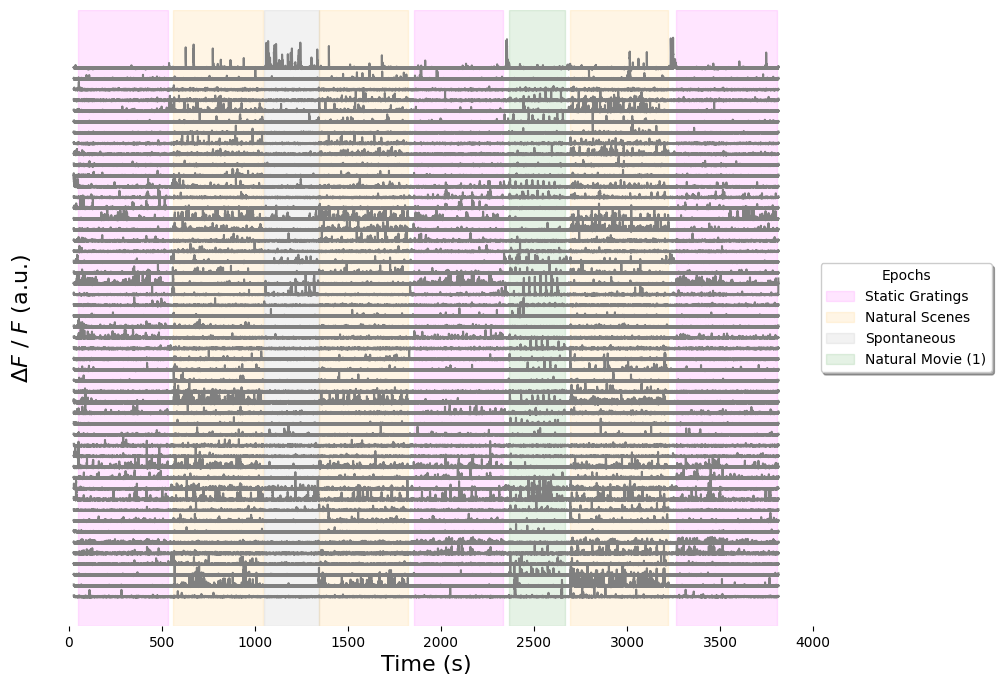

In [41]:
frame = plot_traces(
    timestamps=df_over_f_timestamps,
    traces=df_over_f[:, 0:50],
    figure_shape=(10, 8),
    y_axis_label = "$\Delta F \ / \ F$ (a.u.)",
    trace_color="gray",
    return_frame=True,
)

apply_epoch_shading(frame=frame, epoch_table=epoch_table)

## 3.5 Running speed

This is the running speed of the animal on the rotating disk throughout the entire session.

In [42]:
running_speed = nwbfile.processing["behavior"]["BehavioralTimeSeries"]["running_speed"]
running_speed

running_speed pynwb.base.TimeSeries at 0x1816038843856
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (113723,), type "<f4">
  description: Velocity of the subject over time. Mice were positioned on a running disk during the imaging sessions, and a magnetic shaft encoder (US Digital) attached to this disk recorded the running speed of the mouse during the experiment at 60 samples per second. The running speed was down-sampled to match the timing of the 2-photon imaging (30 Hz).
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (113723,), type "<f8">
  timestamps_unit: seconds
  unit: cm/s

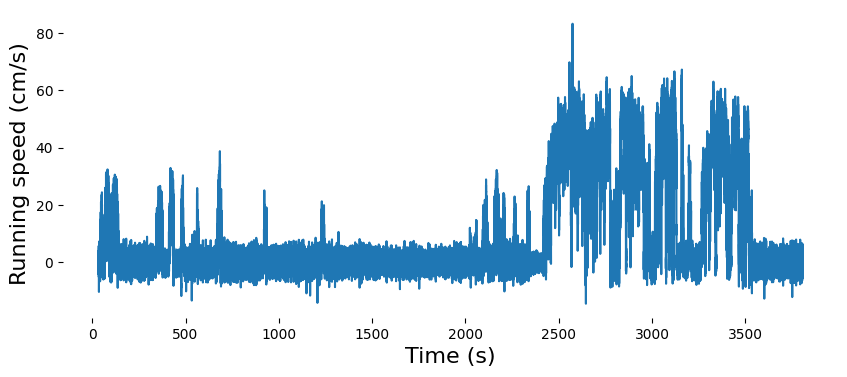

In [43]:
plot_traces(timestamps=running_speed.timestamps[:], traces=running_speed.data[:], hide_y_scale=False, y_axis_label="Running speed (cm/s)")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Now let's combine this with the plots from sections 3.3 & 3.4! 
</div>

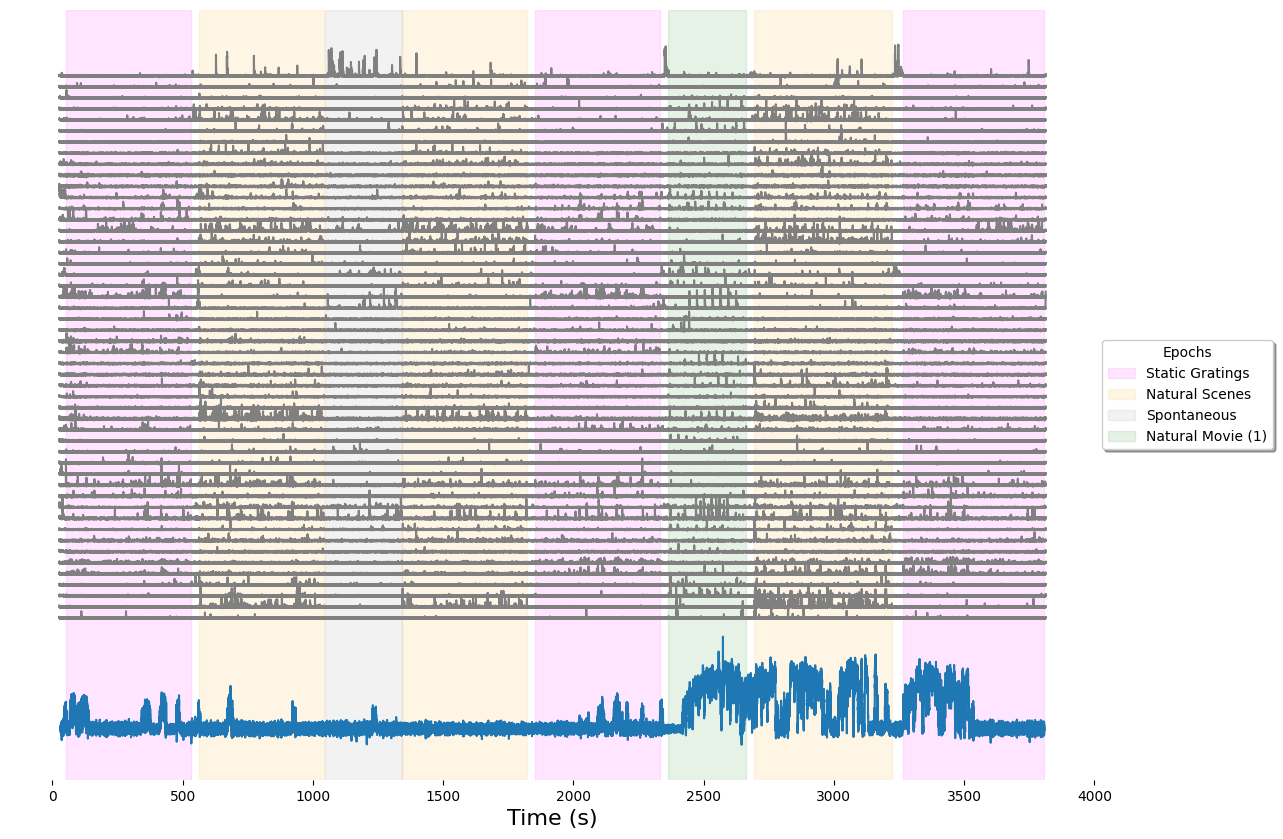

In [44]:
plot_traces(
    timestamps=df_over_f_timestamps,
    traces=df_over_f[:, 0:50],
    figure_shape=(14,10),
    trace_color="gray",
)
frame = plot_traces(
    timestamps=running_speed.timestamps[:],
    traces=(0.2 * running_speed.data[:]) - 20,  # Apply some custom scaling to get both traces on the same x-axis
    reset_figure=False,
    return_frame=True,
)
    
apply_epoch_shading(frame=frame, epoch_table=epoch_table)

### Interesting things

There are some interesting neurons here!

<div class="alert alert-block alert-warning">
Beyond this point, we assume you are using <code>session_id="501559087"</code> to exactly reproduce the plots as shown on GitHub.
<br><br>
While you should probably do this your first time running the notebook - once you are familiar, you should see if the other 1517 sessions can reproduce the same behavior!
</div>

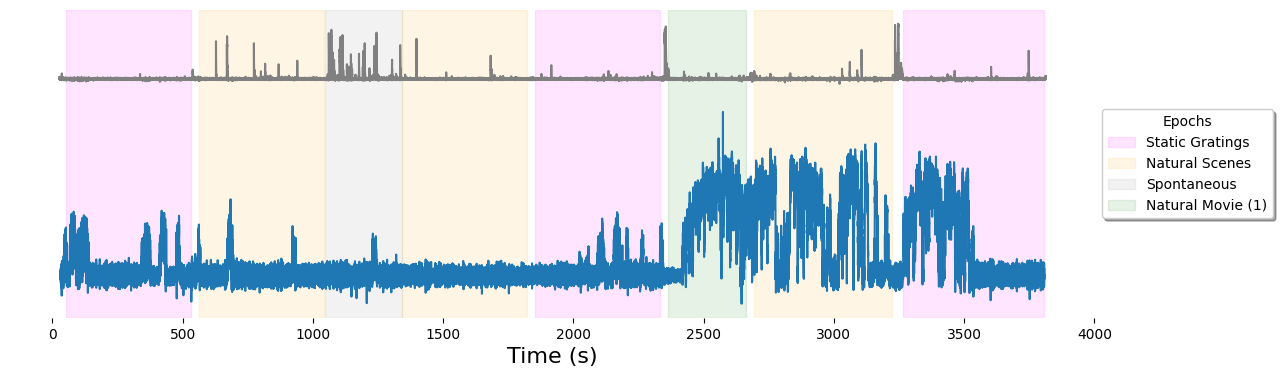

In [45]:
plot_traces(
    timestamps=df_over_f_timestamps,
    traces=df_over_f[:, 49],
    figure_shape=(14,4),
    trace_color="gray",
)
frame = plot_traces(
    timestamps=running_speed.timestamps[:],
    traces=(0.2 * running_speed.data[:]) - 20,  # Apply some custom scaling to get both traces on the same x-axis
    reset_figure=False,
    return_frame=True,
)
    
apply_epoch_shading(frame=frame, epoch_table=epoch_table)

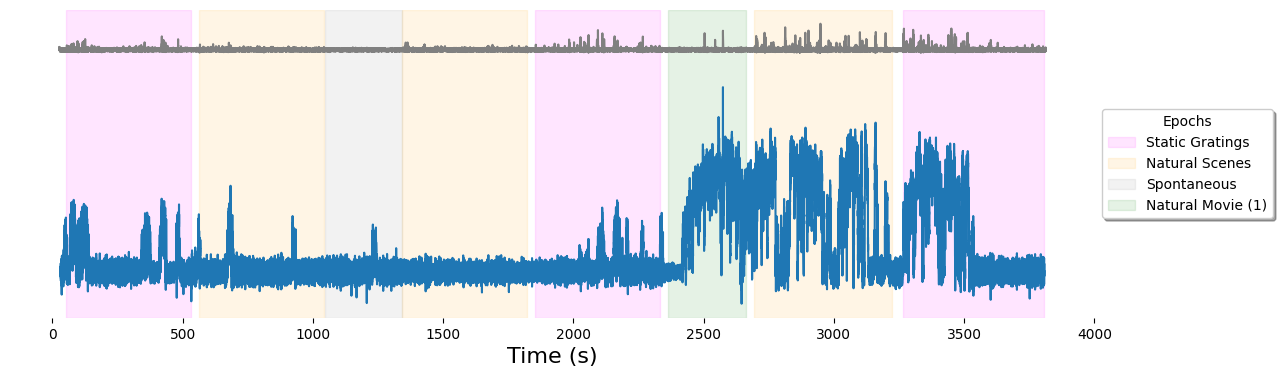

In [46]:
plot_traces(
    timestamps=df_over_f_timestamps,
    traces=df_over_f[:, 4],
    figure_shape=(14,4),
    trace_color="gray",
)
frame = plot_traces(
    timestamps=running_speed.timestamps[:],
    traces=(0.2 * running_speed.data[:]) - 20,  # Apply some custom scaling to get both traces on the same x-axis
    reset_figure=False,
    return_frame=True,
)
    
apply_epoch_shading(frame=frame, epoch_table=epoch_table)

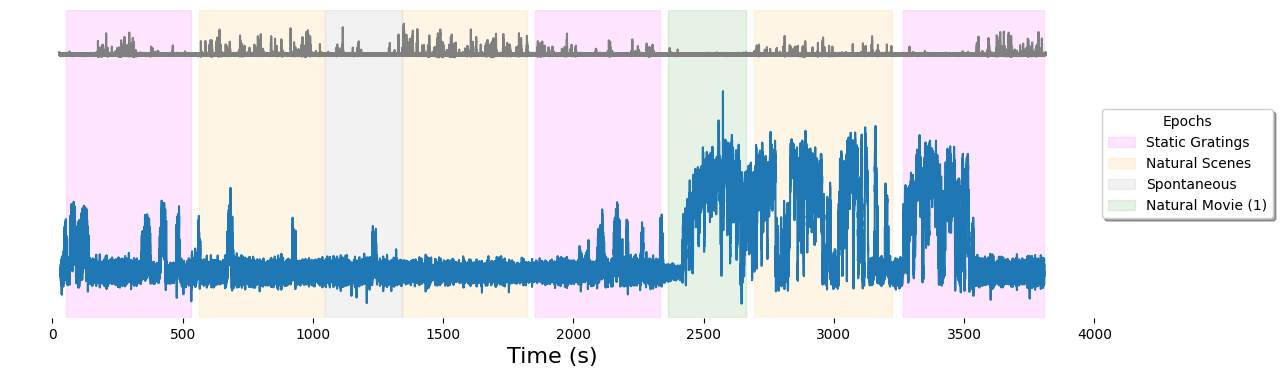

In [47]:
plot_traces(
    timestamps=df_over_f_timestamps,
    traces=df_over_f[:, 35],
    figure_shape=(14,4),
    trace_color="gray",
)
frame = plot_traces(
    timestamps=running_speed.timestamps[:],
    traces=(0.2 * running_speed.data[:]) - 20,  # Apply some custom scaling to get both traces on the same x-axis
    reset_figure=False,
    return_frame=True,
)
    
apply_epoch_shading(frame=frame, epoch_table=epoch_table)

### 3.6 Extracted events from $\Delta F / F$ 

Sean Jewell and Daniella Witten developed an L0 method to extract to events from the $\Delta F / F$ traces.

<div class="alert alert-block alert-warning">
Beyond this point, we assume you are using <code>session_id="501559087"</code> or similar. Most but not all of the sessions in the dataset have identified <code>DFOverFEvents</code> events, so if you have tried to use a different session ID and find it does not have this object, please try another session.
</div>

In [48]:
df_over_f_events = nwbfile.processing["ophys"]["DfOverF"]["DfOverFEvents"]
df_over_f_events

DfOverFEvents pynwb.ophys.RoiResponseSeries at 0x1816073261712
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (113888, 174), type "<f8">
  description: Events from the ΔF/F detected using the L0 method from the AllenSDK. Please consult the AllenSDK for more details of the calculation.
  interval: 1
  offset: 0.0
  resolution: -1.0
  rois: rois <class 'hdmf.common.table.DynamicTableRegion'>
  timestamps: Corrected pynwb.ophys.RoiResponseSeries at 0x1816077614544
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (113888, 174), type "<f4">
  description: Fluorescence per region of interest (ROI) from the raw imaging after spatial demixing and subtraction of neuropil background, but prior to dF/F normalization.
  interval: 1
  offset: 0.0
  resolution: -1.0
  rois: rois <class 'hdmf.common.table.DynamicTableRegion'>
  timestamp_link: (
    DfOverF <class 'pynwb.ophys.RoiResponseSeries'>,
    DfOverFEvents <class 'pynwb.ophys.RoiResponseSeries'>,
    Demixed <class 'pynwb.ophys.RoiResponseSeries'>,
    Neuropil <class 'pynwb.ophys.RoiResponseSeries'>
  )
  timestamps: <HDF5 dataset "timestamps": shape (113888,), type "<f8">
  timestamps_unit: seconds
  unit: n.a.

  timestamps_unit: seconds
  unit: a.u.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's plot both the events and the $\Delta F / F$ trace for one neuron (say neuron index #1).
</div>

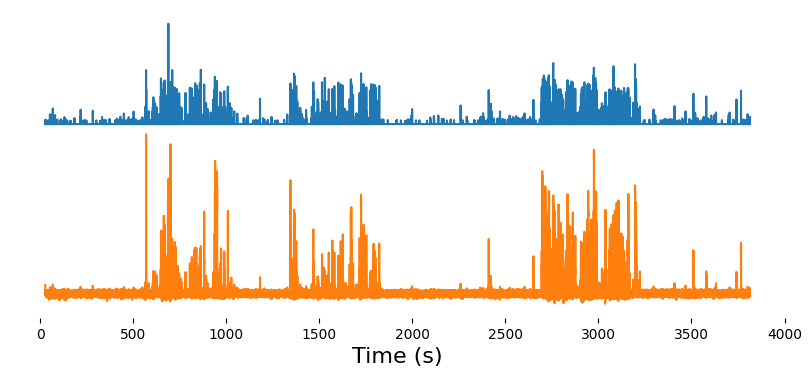

In [49]:
plot_traces(
    timestamps=df_over_f_events.timestamps[:],
    traces=2 * df_over_f_events.data[:, 1],  # Arbitrarily scale by 2 for better appearance
)

plot_traces(
    timestamps=df_over_f_events.timestamps[:],
    traces=df_over_f[:, 1] - 5,  # Arbitrarily shift by 5 for better appearance
    reset_figure=False,
)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Now let's zoom in to a relevant portion.
</div>

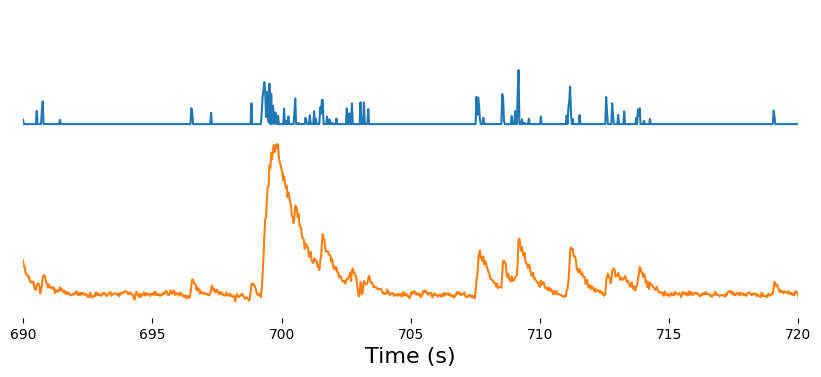

In [50]:
plot_traces(
    timestamps=df_over_f_events.timestamps[:],
    traces=2 * df_over_f_events.data[:, 1],  # Arbitrarily scale by 2 for better appearance
)

plot_traces(
    timestamps=df_over_f_events.timestamps[:],
    traces=df_over_f[:, 1] - 5,  # Arbitrarily shift by 5 for better appearance
    reset_figure=False,
)
matplotlib_pyplot.xlim(690, 720);  # in units seconds

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Now let's remake our plot of neural activty, stimulus, and running, but using the extracted events instead of $\Delta F / F$.
</div>

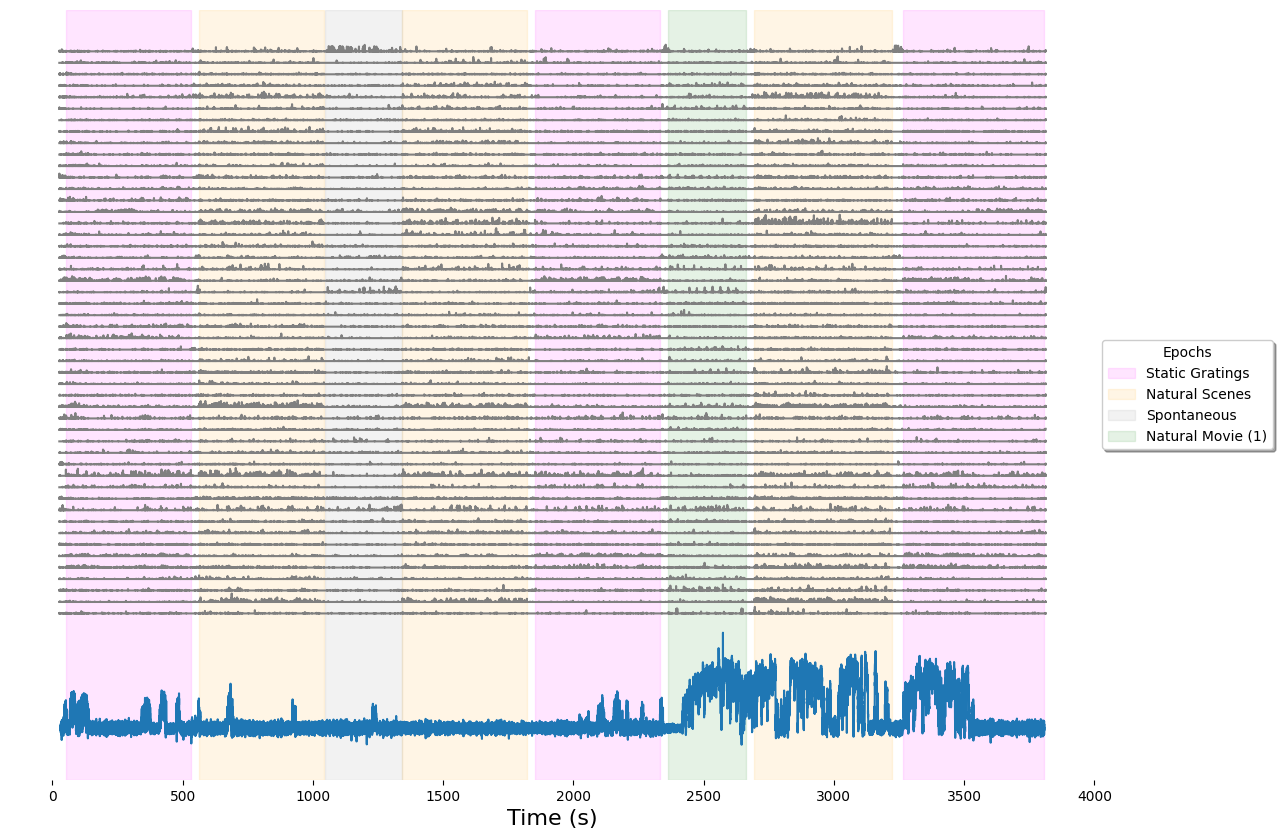

In [51]:
plot_traces(
    timestamps=df_over_f_events.timestamps[:],
    traces=df_over_f_events.data[:, 0:50],
    figure_shape=(14,10),
    trace_color="gray",
)
frame = plot_traces(
    timestamps=running_speed.timestamps[:],
    traces=(0.2 * running_speed.data[:]) - 20,  # Apply some custom scaling to get both traces on the same x-axis
    reset_figure=False,
    return_frame=True,
)
    
apply_epoch_shading(frame=frame, epoch_table=epoch_table)

### 3.7 Stimulus Module

For each stimulus there is a neurodata object with information about the condition and timing of each trial.

### 3.7a Natural Scenes

For the natural scenes, these are `IndexSeries` whose `data` are the indices of the corresponding <b>stimulus template</b> and whose `timestamps` are the time in seconds when each template was presented.

Some sessions may also have 'locally sparse' noise of varying degrees, which can be accessed in an identical fashion.

In [52]:
natural_scene_presentation = nwbfile.stimulus["natural_scenes_stimulus"]
natural_scene_presentation

natural_scenes_stimulus pynwb.image.IndexSeries at 0x1816049828752
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (5950,), type "<u4">
  description: The order and timing for presentation of the natural scene templates.
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (5950,), type "<f8">
  timestamps_unit: seconds
  unit: N/A

In [53]:
natural_scene_presentation = nwbfile.stimulus["natural_scenes_stimulus"]
natural_scene_presentation.data[:]

array([81, 33, 76, ..., 34,  0, 87], dtype=uint32)

In [54]:
natural_scene_presentation.timestamps[:]

array([ 561.98893,  562.25491,  562.48764, ..., 3221.9665 , 3222.23249,
       3222.46524])

The actual images and movies presented during the session area also included in the NWB file as the <b>stimulus template</b>.

Stimuli that are generated programmatically (e.g., drifting and static gratings) do not have a stimulus template.

In [55]:
nwbfile.stimulus_template["natural_scenes_template"]

natural_scenes_template pynwb.base.Images at 0x1816077727952
Fields:
  description: A collection of natural scenes presented to the subject. Lasted for exactly 7 frames.
  images: {
    NaturalScene0 <class 'pynwb.base.Image'>,
    NaturalScene1 <class 'pynwb.base.Image'>,
    NaturalScene10 <class 'pynwb.base.Image'>,
    NaturalScene100 <class 'pynwb.base.Image'>,
    NaturalScene101 <class 'pynwb.base.Image'>,
    NaturalScene102 <class 'pynwb.base.Image'>,
    NaturalScene103 <class 'pynwb.base.Image'>,
    NaturalScene104 <class 'pynwb.base.Image'>,
    NaturalScene105 <class 'pynwb.base.Image'>,
    NaturalScene106 <class 'pynwb.base.Image'>,
    NaturalScene107 <class 'pynwb.base.Image'>,
    NaturalScene108 <class 'pynwb.base.Image'>,
    NaturalScene109 <class 'pynwb.base.Image'>,
    NaturalScene11 <class 'pynwb.base.Image'>,
    NaturalScene110 <class 'pynwb.base.Image'>,
    NaturalScene111 <class 'pynwb.base.Image'>,
    NaturalScene112 <class 'pynwb.base.Image'>,
    NaturalScene113 <class 'pynwb.base.Image'>,
    NaturalScene114 <class 'pynwb.base.Image'>,
    NaturalScene115 <class 'pynwb.base.Image'>,
    NaturalScene116 <class 'pynwb.base.Image'>,
    NaturalScene117 <class 'pynwb.base.Image'>,
    NaturalScene12 <class 'pynwb.base.Image'>,
    NaturalScene13 <class 'pynwb.base.Image'>,
    NaturalScene14 <class 'pynwb.base.Image'>,
    NaturalScene15 <class 'pynwb.base.Image'>,
    NaturalScene16 <class 'pynwb.base.Image'>,
    NaturalScene17 <class 'pynwb.base.Image'>,
    NaturalScene18 <class 'pynwb.base.Image'>,
    NaturalScene19 <class 'pynwb.base.Image'>,
    NaturalScene2 <class 'pynwb.base.Image'>,
    NaturalScene20 <class 'pynwb.base.Image'>,
    NaturalScene21 <class 'pynwb.base.Image'>,
    NaturalScene22 <class 'pynwb.base.Image'>,
    NaturalScene23 <class 'pynwb.base.Image'>,
    NaturalScene24 <class 'pynwb.base.Image'>,
    NaturalScene25 <class 'pynwb.base.Image'>,
    NaturalScene26 <class 'pynwb.base.Image'>,
    NaturalScene27 <class 'pynwb.base.Image'>,
    NaturalScene28 <class 'pynwb.base.Image'>,
    NaturalScene29 <class 'pynwb.base.Image'>,
    NaturalScene3 <class 'pynwb.base.Image'>,
    NaturalScene30 <class 'pynwb.base.Image'>,
    NaturalScene31 <class 'pynwb.base.Image'>,
    NaturalScene32 <class 'pynwb.base.Image'>,
    NaturalScene33 <class 'pynwb.base.Image'>,
    NaturalScene34 <class 'pynwb.base.Image'>,
    NaturalScene35 <class 'pynwb.base.Image'>,
    NaturalScene36 <class 'pynwb.base.Image'>,
    NaturalScene37 <class 'pynwb.base.Image'>,
    NaturalScene38 <class 'pynwb.base.Image'>,
    NaturalScene39 <class 'pynwb.base.Image'>,
    NaturalScene4 <class 'pynwb.base.Image'>,
    NaturalScene40 <class 'pynwb.base.Image'>,
    NaturalScene41 <class 'pynwb.base.Image'>,
    NaturalScene42 <class 'pynwb.base.Image'>,
    NaturalScene43 <class 'pynwb.base.Image'>,
    NaturalScene44 <class 'pynwb.base.Image'>,
    NaturalScene45 <class 'pynwb.base.Image'>,
    NaturalScene46 <class 'pynwb.base.Image'>,
    NaturalScene47 <class 'pynwb.base.Image'>,
    NaturalScene48 <class 'pynwb.base.Image'>,
    NaturalScene49 <class 'pynwb.base.Image'>,
    NaturalScene5 <class 'pynwb.base.Image'>,
    NaturalScene50 <class 'pynwb.base.Image'>,
    NaturalScene51 <class 'pynwb.base.Image'>,
    NaturalScene52 <class 'pynwb.base.Image'>,
    NaturalScene53 <class 'pynwb.base.Image'>,
    NaturalScene54 <class 'pynwb.base.Image'>,
    NaturalScene55 <class 'pynwb.base.Image'>,
    NaturalScene56 <class 'pynwb.base.Image'>,
    NaturalScene57 <class 'pynwb.base.Image'>,
    NaturalScene58 <class 'pynwb.base.Image'>,
    NaturalScene59 <class 'pynwb.base.Image'>,
    NaturalScene6 <class 'pynwb.base.Image'>,
    NaturalScene60 <class 'pynwb.base.Image'>,
    NaturalScene61 <class 'pynwb.base.Image'>,
    NaturalScene62 <class 'pynwb.base.Image'>,
    NaturalScene63 <class 'pynwb.base.Image'>,
    NaturalScene64 <class 'pynwb.base.Image'>,
    NaturalScene65 <class 'pynwb.base.Image'>,


In [56]:
natural_scene_template = nwbfile.stimulus_template["natural_scenes_template"]
natural_scene_template

natural_scenes_template pynwb.base.Images at 0x1816077727952
Fields:
  description: A collection of natural scenes presented to the subject. Lasted for exactly 7 frames.
  images: {
    NaturalScene0 <class 'pynwb.base.Image'>,
    NaturalScene1 <class 'pynwb.base.Image'>,
    NaturalScene10 <class 'pynwb.base.Image'>,
    NaturalScene100 <class 'pynwb.base.Image'>,
    NaturalScene101 <class 'pynwb.base.Image'>,
    NaturalScene102 <class 'pynwb.base.Image'>,
    NaturalScene103 <class 'pynwb.base.Image'>,
    NaturalScene104 <class 'pynwb.base.Image'>,
    NaturalScene105 <class 'pynwb.base.Image'>,
    NaturalScene106 <class 'pynwb.base.Image'>,
    NaturalScene107 <class 'pynwb.base.Image'>,
    NaturalScene108 <class 'pynwb.base.Image'>,
    NaturalScene109 <class 'pynwb.base.Image'>,
    NaturalScene11 <class 'pynwb.base.Image'>,
    NaturalScene110 <class 'pynwb.base.Image'>,
    NaturalScene111 <class 'pynwb.base.Image'>,
    NaturalScene112 <class 'pynwb.base.Image'>,
    NaturalScene113 <class 'pynwb.base.Image'>,
    NaturalScene114 <class 'pynwb.base.Image'>,
    NaturalScene115 <class 'pynwb.base.Image'>,
    NaturalScene116 <class 'pynwb.base.Image'>,
    NaturalScene117 <class 'pynwb.base.Image'>,
    NaturalScene12 <class 'pynwb.base.Image'>,
    NaturalScene13 <class 'pynwb.base.Image'>,
    NaturalScene14 <class 'pynwb.base.Image'>,
    NaturalScene15 <class 'pynwb.base.Image'>,
    NaturalScene16 <class 'pynwb.base.Image'>,
    NaturalScene17 <class 'pynwb.base.Image'>,
    NaturalScene18 <class 'pynwb.base.Image'>,
    NaturalScene19 <class 'pynwb.base.Image'>,
    NaturalScene2 <class 'pynwb.base.Image'>,
    NaturalScene20 <class 'pynwb.base.Image'>,
    NaturalScene21 <class 'pynwb.base.Image'>,
    NaturalScene22 <class 'pynwb.base.Image'>,
    NaturalScene23 <class 'pynwb.base.Image'>,
    NaturalScene24 <class 'pynwb.base.Image'>,
    NaturalScene25 <class 'pynwb.base.Image'>,
    NaturalScene26 <class 'pynwb.base.Image'>,
    NaturalScene27 <class 'pynwb.base.Image'>,
    NaturalScene28 <class 'pynwb.base.Image'>,
    NaturalScene29 <class 'pynwb.base.Image'>,
    NaturalScene3 <class 'pynwb.base.Image'>,
    NaturalScene30 <class 'pynwb.base.Image'>,
    NaturalScene31 <class 'pynwb.base.Image'>,
    NaturalScene32 <class 'pynwb.base.Image'>,
    NaturalScene33 <class 'pynwb.base.Image'>,
    NaturalScene34 <class 'pynwb.base.Image'>,
    NaturalScene35 <class 'pynwb.base.Image'>,
    NaturalScene36 <class 'pynwb.base.Image'>,
    NaturalScene37 <class 'pynwb.base.Image'>,
    NaturalScene38 <class 'pynwb.base.Image'>,
    NaturalScene39 <class 'pynwb.base.Image'>,
    NaturalScene4 <class 'pynwb.base.Image'>,
    NaturalScene40 <class 'pynwb.base.Image'>,
    NaturalScene41 <class 'pynwb.base.Image'>,
    NaturalScene42 <class 'pynwb.base.Image'>,
    NaturalScene43 <class 'pynwb.base.Image'>,
    NaturalScene44 <class 'pynwb.base.Image'>,
    NaturalScene45 <class 'pynwb.base.Image'>,
    NaturalScene46 <class 'pynwb.base.Image'>,
    NaturalScene47 <class 'pynwb.base.Image'>,
    NaturalScene48 <class 'pynwb.base.Image'>,
    NaturalScene49 <class 'pynwb.base.Image'>,
    NaturalScene5 <class 'pynwb.base.Image'>,
    NaturalScene50 <class 'pynwb.base.Image'>,
    NaturalScene51 <class 'pynwb.base.Image'>,
    NaturalScene52 <class 'pynwb.base.Image'>,
    NaturalScene53 <class 'pynwb.base.Image'>,
    NaturalScene54 <class 'pynwb.base.Image'>,
    NaturalScene55 <class 'pynwb.base.Image'>,
    NaturalScene56 <class 'pynwb.base.Image'>,
    NaturalScene57 <class 'pynwb.base.Image'>,
    NaturalScene58 <class 'pynwb.base.Image'>,
    NaturalScene59 <class 'pynwb.base.Image'>,
    NaturalScene6 <class 'pynwb.base.Image'>,
    NaturalScene60 <class 'pynwb.base.Image'>,
    NaturalScene61 <class 'pynwb.base.Image'>,
    NaturalScene62 <class 'pynwb.base.Image'>,
    NaturalScene63 <class 'pynwb.base.Image'>,
    NaturalScene64 <class 'pynwb.base.Image'>,
    NaturalScene65 <class 'pynwb.base.Image'>,


In [57]:
len(natural_scene_template.images)

118

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's plot the natural scene image indexed at #101.
</div>

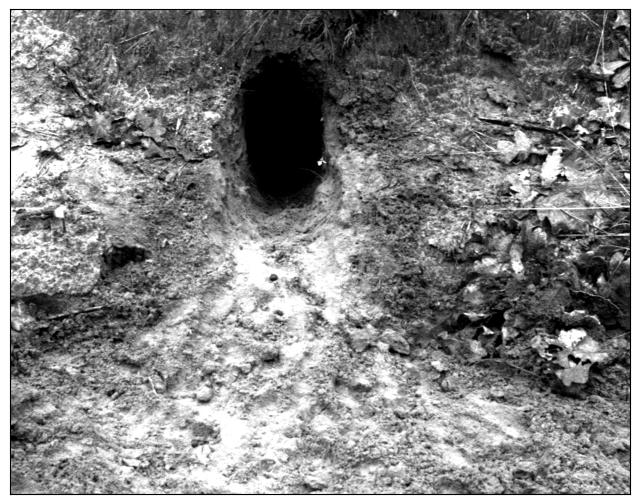

In [58]:
scene_number = 101

plot_image(image=natural_scene_template[f"NaturalScene{scene_number}"], color_map="gray")

Use the stimulus table to plot the responses of cell index 1 to image 101

### 3.7b Natural Movies

The natural movies are very similar to the natural scenes, except that their `data` are the indices to a single `ImageSeries` (instead of multiple `Image` objects stored in an `Image` container) found in the templates.

In [59]:
natural_movie_one_presentation = nwbfile.stimulus["natural_movie_one_stimulus"]
natural_movie_one_presentation

natural_movie_one_stimulus pynwb.image.IndexSeries at 0x1816073340880
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (9000,), type "<u4">
  description: The order and timing for presentation of frames from the the natural movie templates.
  indexed_timeseries: natural_movie_one pynwb.image.ImageSeries at 0x1816073245520
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (900, 304, 608), type "|u1">
  description: A natural movie presented to the subject.
  device: StimulusDisplay pynwb.device.Device at 0x1816077727568
Fields:
  description: An ASUS PA248Q monitor used to display visual stimuli.
  manufacturer: ASUS

  offset: 0.0
  rate: nan
  resolution: -1.0
  starting_time: nan
  starting_time_unit: seconds
  unit: n.a.

  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (9000,), type "<f8">
  timestamps_unit: seconds
  unit: N/A

In [60]:
natural_movie_one_template = nwbfile.stimulus_template["natural_movie_one"]
natural_movie_one_template

natural_movie_one pynwb.image.ImageSeries at 0x1816073245520
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (900, 304, 608), type "|u1">
  description: A natural movie presented to the subject.
  device: StimulusDisplay pynwb.device.Device at 0x1816077727568
Fields:
  description: An ASUS PA248Q monitor used to display visual stimuli.
  manufacturer: ASUS

  offset: 0.0
  rate: nan
  resolution: -1.0
  starting_time: nan
  starting_time_unit: seconds
  unit: n.a.

In [61]:
natural_movie_one_template.data.shape

(900, 304, 608)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's plot the image of the frame index #101 from the natural movie.
</div>

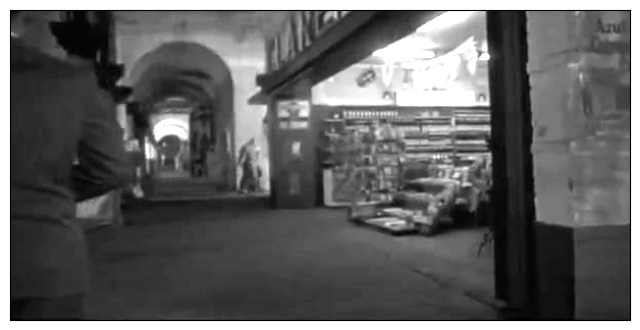

In [62]:
frame_index = 101

plot_image(image=natural_movie_one_template.data[frame_index, ...], color_map="gray")

### 3.7c Static Gratings

For the static gratings, these are simple a table with the corresponding parameters that were varied on each presentation.

In [63]:
static_gratings_table = nwbfile.stimulus["static_gratings"]
static_gratings_table.to_dataframe()
#static_gratings_table.head()

start_time  stop_time  orientation_in_degrees  \
id                                                  
0     51.55381   51.80381                    90.0   
1     51.78653   52.03653                   150.0   
2     52.05250   52.30250                    30.0   

    spatial_frequency_in_cycles_per_degree  phase  is_blank_sweep  
id                                                                 
0                                     0.04    0.5           False  
1                                     0.04    0.5           False  
2                                     0.02    0.0           False

<div class="alert alert-block alert-info">
What does each of these parameters mean?
<br><br>
You can always access descriptions of such columns if you're wondering about what each one means in the context of the experiment.
</div>

In [64]:
static_gratings_column_descriptions = {column.name: column.description for column in static_gratings_table.columns}
static_gratings_column_descriptions

{'start_time': 'Start time of epoch, in seconds',
 'stop_time': 'Stop time of epoch, in seconds',
 'orientation_in_degrees': 'Angle of the grating in degrees. NaN values correspond to a blank sweep.',
 'spatial_frequency_in_cycles_per_degree': 'Period of the grating in cycles/degree. NaN values correspond to a blank sweep.',
 'phase': 'Relative position of the grating. Phase 0 and Phase 0.5 are 180° apart so that the peak of the grating of phase 0 lines up with the trough of phase 0.5. NaN values correspond to a blank sweep.',
 'is_blank_sweep': 'Mean luminance gray image.'}

### 3.7 Drifting Gratings

To examine the drifting gratings, we will have to open a stream to a separate session file.

The drifting gratings are also a table with the corresponding parameters that were varied on each presentation.

In [65]:
session_id_with_drifting_gratings = "501940850"

nwbfile_with_drifting_gratings = read_visual_coding_ophys_file(dandiset=dandiset, session_id=session_id_with_drifting_gratings)

In [66]:
drifting_gratings = nwbfile_with_drifting_gratings.stimulus["drifting_gratings"]
drifting_gratings

drifting_gratings pynwb.epoch.TimeIntervals at 0x1814825251344
Fields:
  colnames: ['start_time' 'stop_time' 'orientation_in_degrees'
 'spatial_frequency_in_cycles_per_degree' 'temporal_frequency_in_hz'
 'is_blank_sweep']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    orientation_in_degrees <class 'hdmf.common.table.VectorData'>,
    spatial_frequency_in_cycles_per_degree <class 'hdmf.common.table.VectorData'>,
    temporal_frequency_in_hz <class 'hdmf.common.table.VectorData'>,
    is_blank_sweep <class 'hdmf.common.table.VectorData'>
  )
  description: Parameterizations of full field drifting sinusoidal grating at a single spatial contrast (80%). Direction of motion is to the orientation of the grating.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

In [67]:
drifting_gratings_column_descriptions = {column.name: column.description for column in drifting_gratings.columns}
drifting_gratings_column_descriptions

{'start_time': 'Start time of epoch, in seconds',
 'stop_time': 'Stop time of epoch, in seconds',
 'orientation_in_degrees': 'Angle of the grating in degrees. NaN values correspond to a blank sweep.',
 'spatial_frequency_in_cycles_per_degree': 'Period of the grating in cycles/degree. NaN values correspond to a blank sweep.',
 'temporal_frequency_in_hz': 'The speed at which the grating moves in Hz. NaN values correspond to a blank sweep.',
 'is_blank_sweep': 'Mean luminance gray image.'}

<div style="background: #C6D9F1; border-radius: 5px; padding: 10px;">

<h1>Part 4: Compute activity aligned to stimulus presentations</h1>

</div>

<div class="alert alert-block alert-info">
Remember earlier when we mentioned not slicing the data object meant we kept it 'lazy'? This can be really convenient for very large datasets where loading too much into memory at a time could overload our system.
<br><br>
But it can also decrease the speed of repeated operations - so we'll go ahead and load all the data using <code>[...]</code> for these next steps!
</div>

In [68]:
df_over_f = df_over_f[...]

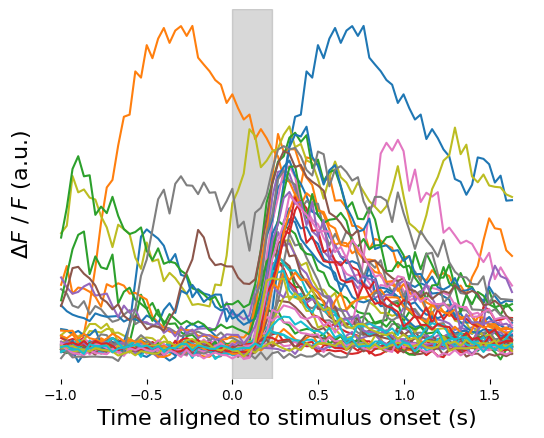

In [69]:
scene_number = 101
cell_index = 1

times_when_scene_was_presented = natural_scene_presentation.timestamps[natural_scene_presentation.data[:] == scene_number]

# Applying 30 frames of buffer room before and 50 after
df_over_f_times_to_frames = numpy.searchsorted(df_over_f_timestamps, times_when_scene_was_presented)

for df_over_f_time_to_frame in df_over_f_times_to_frames[:]:
    subset_df_over_f_frames = slice(df_over_f_time_to_frame - 30, df_over_f_time_to_frame + 50)

    timestamps = df_over_f_timestamps[subset_df_over_f_frames]
    aligned_timestamps = timestamps - timestamps[30]
    
    frame = plot_traces(
        timestamps=aligned_timestamps,
        traces=df_over_f[subset_df_over_f_frames, cell_index],
        x_axis_label="Time aligned to stimulus onset (s)",
        y_axis_label="$\Delta F \ / \ F$ (a.u.)",
        reset_figure=False,
        return_frame=True,
    )

# Here, we use the fact about duration of the stimulusu learned from the description of the NaturalScene objects
frame.axvspan(aligned_timestamps[30], aligned_timestamps[37], color="gray", alpha=0.3);

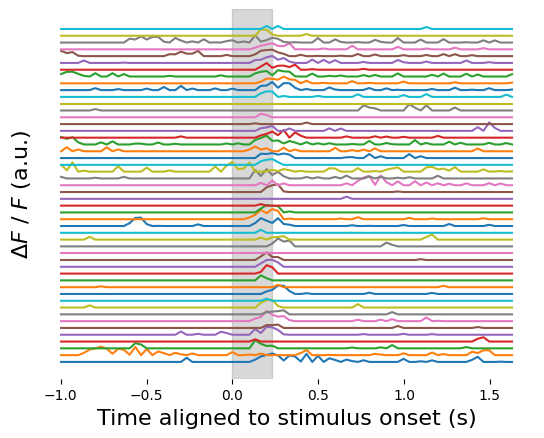

In [70]:
scene_number = 101
cell_index = 1

times_when_scene_was_presented = natural_scene_presentation.timestamps[natural_scene_presentation.data[:] == scene_number]

# Applying 30 frames of buffer room before and 50 after
df_over_f_times_to_frames = numpy.searchsorted(df_over_f_timestamps, times_when_scene_was_presented)
timestamps = df_over_f_timestamps[subset_df_over_f_frames]
aligned_timestamps = timestamps - timestamps[30]

for presentation_index, df_over_f_time_to_frame in enumerate(df_over_f_times_to_frames[:], start=1):
    subset_df_over_f_frames = slice(df_over_f_time_to_frame - 30, df_over_f_time_to_frame + 50)

    frame = plot_traces(
        timestamps=aligned_timestamps,
        traces=2 * df_over_f_events.data[subset_df_over_f_frames, cell_index] + presentation_index,
        reset_figure=False,
        x_axis_label="Time aligned to stimulus onset (s)",
        y_axis_label="$\Delta F \ / \ F$ (a.u.)",
        return_frame=True,
    )

# Here, we use the fact about duration of the stimulusu learned from the description of the NaturalScene objects
frame.axvspan(aligned_timestamps[30], aligned_timestamps[37], color="gray", alpha=0.3);

<div style="background: #C6D9F1; border-radius: 5px; padding: 10px;">

<h1>Part 5: Compute the signal correlations as a function of distance between neurons</h1>

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's compute the mean response for each neuron in the experiment for each image of the natural scene stimulus.
</div>

In [71]:
number_of_rois = df_over_f.shape[1]
number_of_natural_scenes = len(natural_scene_template.images)

response = numpy.empty(shape=(number_of_rois, number_of_natural_scenes))
for roi_index in range(number_of_rois):
    for scene_number in range(number_of_natural_scenes):
        times_when_scene_was_presented = natural_scene_presentation.timestamps[natural_scene_presentation.data[:] == scene_number]
        df_over_f_times_to_frames = numpy.searchsorted(df_over_f_timestamps, times_when_scene_was_presented)
        
        # Take the mean over a very short period just after stimulus onset (15 frames)
        frames_before_onset = 0
        frames_after_onset = 15
        temp = numpy.empty(shape=(frames_after_onset + frames_before_onset, len(times_when_scene_was_presented)))
        for temp_index, df_over_f_time_to_frame in enumerate(df_over_f_times_to_frames):
            subset_df_over_f_frames = slice(df_over_f_time_to_frame - frames_before_onset, df_over_f_time_to_frame + frames_after_onset)

            temp[:, temp_index] = df_over_f[subset_df_over_f_frames, roi_index]
        response[roi_index, scene_number] = temp.mean()

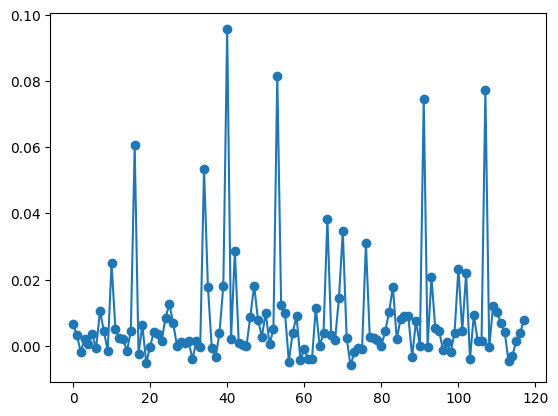

In [72]:
matplotlib_pyplot.plot(response[0,:], 'o-');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's compute the signal correlation between all neuron pairs.
<br><br>    
This is the correlation of the mean response to all images.
</div>

In [73]:
signal_correlations = numpy.empty(shape=(number_of_rois, number_of_rois))
for roi_index_1 in range(number_of_rois):
    for roi_index_2 in range(number_of_rois):
        r, p = scipy_stats.pearsonr(response[roi_index_1, :], response[roi_index_2, :])
        signal_correlations[roi_index_1, roi_index_2] = r

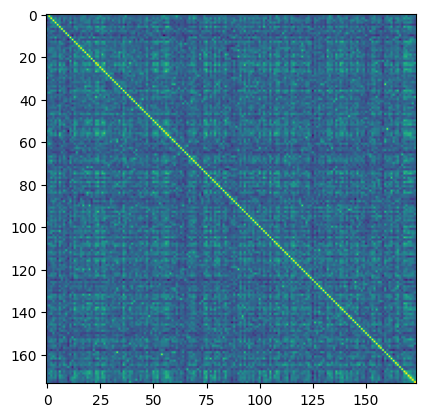

In [74]:
matplotlib_pyplot.imshow(signal_correlations);

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's use the ROI masks to calculate the distance between each pair of neurons.
</div>

In [75]:
pixel_masks = plane_segmentation["pixel_mask"][:]
centroid_x = numpy.zeros(shape=number_of_rois)
centroid_y = numpy.zeros(shape=number_of_rois)

for roi_index, pixel_mask in enumerate(pixel_masks):
    centroid_x[roi_index] = numpy.mean([pixel[0] for pixel in pixel_mask])
    centroid_y[roi_index] = numpy.mean([pixel[1] for pixel in pixel_mask])

distance = numpy.zeros(shape=(number_of_rois, number_of_rois))
for roi_index_1 in range(number_of_rois):
    for roi_index_2 in range(number_of_rois):
        distance[roi_index_1, roi_index_2] = numpy.sqrt(
            (centroid_x[roi_index_1] - centroid_x[roi_index_2])**2 + (centroid_y[roi_index_1] - centroid_y[roi_index_2])**2 
        )

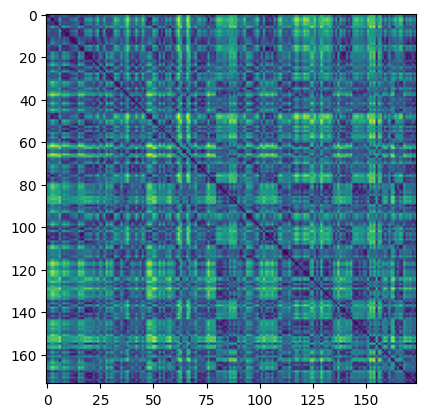

In [76]:
matplotlib_pyplot.imshow(distance);

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px">
Let's plot the signal correlations as a function of distance of each pair of neurons.
</div>

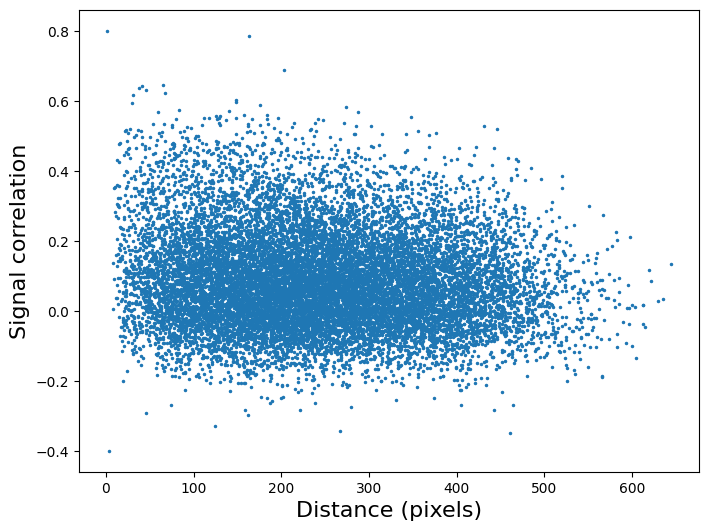

In [77]:
# Only use the upper half of the matrix due to symmetry of correlation
indices = numpy.triu_indices(number_of_rois, k=1)

matplotlib_pyplot.figure(figsize=(8,6))
matplotlib_pyplot.plot(distance[indices[0], indices[1]], signal_correlations[indices[0], indices[1]], ".", markersize=3.0)
matplotlib_pyplot.xlabel("Distance (pixels)", fontsize=16)
matplotlib_pyplot.ylabel("Signal correlation", fontsize=16);

<div style="background: #C6D9F1; border-radius: 5px; padding: 1px">

<h1>Conclusion</h1>

</div>

The Allen Brain Observatory - Visual Coding (Ophys) is a rich dataset that allows you to explore single cell and population responses across 6 cortical areas, 4 cortical layers, 14 transgenic Cre lines to a range of different visual stimuli.

This tutorial should enable you to get started in using these data including finding experiments and accessing the neural and behavioral data, along with stimulus information.